In [2]:
import pandas as pd 
import umap
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
import plotly.express as px
from functions.common_functions import *
import rdkit
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
import os 
from rdkit.Chem import rdMolTransforms

In [3]:




def mol_to_grid(mol):
    coordinates = []
    IDs = []
    stat=AllChem.EmbedMolecule(mol)
    Chem.rdDistGeom.EmbedMolecule(mol)
    conf=mol.GetConformer(0)
    rdMolTransforms.CanonicalizeConformer(conf)
    if stat==-1:
        print("Wrong conf!!")

        return coordinates,IDs
        
    else:
        for i, atom in enumerate(mol.GetAtoms()):
            atom_ID = atom.GetIdx()
            conf = mol.GetConformer(0).GetAtomPosition(i)
            position_x = float(conf[0])
            position_y = float(conf[1])
            position_z = float(conf[2])
            coordinates.append([position_x,position_y,position_z])
            IDs.append(int(atom_ID))
        return coordinates,IDs

def find_candidates(mol,atom_type="N",Degree=2):
        atom_IDs = []
        for i, atom in enumerate(mol.GetAtoms()):
            if str(atom.GetSymbol()) == atom_type and int(atom.GetDegree()) == Degree:
                atom_IDs.append(int(atom.GetIdx())+1)
        return atom_IDs      

def make_grid(sml, find_cand=False, atom_type="N",Degree=2,add_H=True):
    
    mol = Chem.MolFromSmiles(sml)
    if add_H:
        mol = Chem.AddHs(mol)
    G, IDs  = mol_to_grid(mol)
    if len(G)==0:
        
        ID_grid=[] 
        adj=[]
        return  ID_grid, adj
    adj = Chem.rdmolops.GetAdjacencyMatrix(mol)

    if find_cand:
        cand_ids = find_candidates(mol,atom_type,Degree)
        return G, adj, cand_ids
    else:
        return G, adj


In [4]:
full_df=pd.read_csv("mannich_database_processed.csv")

In [5]:
cat_grid = []
labels = []
ID_cat_grid = []
ID_sub_grid = []
adjeciency_mat_sub = []
adjeciency_mat_cat = []
candidates = []
cat_uniq = np.unique(full_df.Catalyst)
"""for i in range(len(cat_uniq)):
        #try:        
                ID, adj = make_grid(cat_uniq[i], find_cand=False,add_H=True)  
                ID_cat_grid.append(ID)
                adjeciency_mat_cat.append(adj)"""
                

sub_uniq = np.unique(full_df.Imine_SMILES)
sub_grid = []

for i in range(len(sub_uniq)):
        ID, adj, cand_ids = make_grid(sub_uniq[i], find_cand=True)
        
        ID_sub_grid.append(ID)
        adjeciency_mat_sub.append(adj)
        candidates.append(cand_ids)


In [6]:
def line_equation_from_points(point1, point2):
    # Calculate coefficients of the line equation Ax + By + Cz + D = 0 from two points
    x1, y1, z1 = point1
    x2, y2, z2 = point2
    A = y1*z2 - y2*z1
    B = x2*z1 - x1*z2
    C = x1*y2 - x2*y1
    D = -(A*x1 + B*y1 + C*z1)
    return A, B, C, D

def distance_point_to_line(point, line_start, line_end):
    A, B, C, D = line_equation_from_points(line_start, line_end)
    x1, y1, z1 = point
    distance = abs(A*x1 + B*y1 + C*z1 + D) / np.sqrt(A**2 + B**2 + C**2)
    return distance
def distance_point_to_segment(point, segment_start, segment_end):
    # Convert inputs to numpy arrays for vector operations
    point = np.array(point)
    segment_start = np.array(segment_start)
    segment_end = np.array(segment_end)
    
    # Vector representing the segment
    segment_vector = segment_end - segment_start
    
    # Vector from segment start to the point
    start_to_point_vector = point - segment_start
    
    # Projection parameter t along the segment
    t = np.dot(start_to_point_vector, segment_vector) / np.dot(segment_vector, segment_vector)
    
    # Calculate the closest point on the segment to the point
    t = np.clip(t, 0.0, 1.0)  # Clamp t to the range [0, 1]
    closest_point = segment_start + t * segment_vector
    
    # Calculate the distance between the point and the closest point on the segment
    distance = np.linalg.norm(point - closest_point)
    
    return distance

def shortest_distance_between_segments(A, B, C, D):
    # Calculate vectors for line segment AB and CD
    e1 = (np.array(B) - np.array(A))/np.linalg.norm(np.array(B) - np.array(A))
    e2 = (np.array(D) - np.array(C))/np.linalg.norm(np.array(D) - np.array(C))
    
    # Vector from A to C
    AC = np.array(C) - np.array(A)
    

    dot_e1_AC = np.dot(e1, AC)
    dot_e2_AC = np.dot(e2, AC)
    dot_e1_e2 = np.dot(e1, e2)
    # Calculate parameters t and s
    denominator = 1 - dot_e1_e2**2
    
    if denominator == 0:
        # Segments are parallel; return distance between point A and segment CD
        return distance_point_to_segment(A, C, D)
    
    t = (dot_e1_AC - dot_e2_AC*dot_e1_e2) / denominator
    s = (dot_e2_AC - dot_e1_AC*dot_e1_e2) / denominator
    
    # Calculate closest points on the segments
    closest_point_on_AB = np.clip(A + t * (np.array(B) - np.array(A)), A, B)
    closest_point_on_CD = np.clip(C + s * (np.array(D) - np.array(C)), C, D)
    
    # Calculate the distance between the closest points
    shortest_distance = np.linalg.norm(closest_point_on_AB - closest_point_on_CD)
    
    return shortest_distance



def spherical_to_cartesian(radius, inclination, azimuth):
    # Convert spherical coordinates to Cartesian coordinates
    x = radius * np.sin(inclination) * np.cos(azimuth)
    y = radius * np.sin(inclination) * np.sin(azimuth)
    z = radius * np.cos(inclination)
    return x, y, z

def distance_point_to_spherical_line(point, line_start, radius, inclination, azimuth):
    # Convert spherical coordinates to Cartesian coordinates
    line_end = spherical_to_cartesian(radius, inclination, azimuth)
    
    # Use the previous function to calculate distance from point to line
    return distance_point_to_line(point, line_start, line_end)


In [7]:
def create_lines_from_adjacency_matrix(matrix_ids, adjacency_matrix,cand_id):
    """
    Create lines between objects based on an adjacency matrix and positions in the empty grid.

    Parameters:
        empty_grid (numpy.ndarray): The 3D grid with occupied and empty points.
        adjacency_matrix (numpy.ndarray): The adjacency matrix representing connections between objects.

    Returns:
        plotly.graph_objs.Scatter3d: A Plotly Scatter3d object representing the lines between connected objects.
    """
    line_coords =[]
    num_objects = len(matrix_ids)


    for i in range(num_objects):
        for j in range(i , num_objects):
            if adjacency_matrix[i, j] == 1 and i !=cand_id and j!=cand_id:
                # Find the positions of the connected objects
                obj1_positions = matrix_ids[j]
                obj2_positions = matrix_ids[i]

                # Create lines between connected objects
                line_coords.append((obj1_positions, obj2_positions))
    
    return line_coords

In [8]:

def place_evenly_spaced_lines(positions, line_coords, cand_id, center, N,atomic_radi,bond_radi,max_distance=20,min_distance=0):
    """
    Place N evenly spaced lines from the center in a 3D grid.

    Parameters:
        grid_shape (tuple): The shape of the 3D grid (x, y, z).
        center (tuple): The coordinates of the center point (x_center, y_center, z_center).
        N (int): The number of lines to place.

    Returns:
        list: A list of lines, where each line is represented as a list of grid points.
        int: The number of lines that pass through occupied space.
    """
    
   
    
    lines = []
    occupied_lines_count = 0

    positions = positions
    # Calculate the directions of the evenly spaced lines in spherical coordinates
    theta_values = np.linspace(0, 2 * np.pi, N//2, endpoint=False)  # Azimuthal angle
    phi_values = np.linspace(0, np.pi, N//2, endpoint=False)  # Polar angle

    for theta in theta_values:
       for phi in phi_values:
        # Convert spherical coordinates to Cartesian coordinates for direction vector
        direction = np.array([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ])
        crossed_occupied_space = False
        line_end = np.array(center) + max_distance*direction
        line_begining = np.array(center) + min_distance*direction
            # Check if any position is within radius -r of the line
        for i in range(len(positions)):
            
            if i!=cand_id:    
                position = positions[i]
                distance = distance_point_to_segment(position, line_begining, line_end)
                
                if distance <= atomic_radi:
                    occupied_lines_count += 1
                    crossed_occupied_space = True
                    break  # No need to check further positions for this line
        if not crossed_occupied_space:
            for line in line_coords:
                    distance = shortest_distance_between_segments(line[0], line[1], line_begining, line_end)
                    
                    if distance <= bond_radi:
                        occupied_lines_count += 1
                        crossed_occupied_space = True
                        break  # No need to check further positions for this line

   
        lines.append((center, line_end,crossed_occupied_space))
    return lines, occupied_lines_count
"""

center = ID_sub_grid[10][3]

lines = create_lines_from_adjacency_matrix(ID_sub_grid[10], adjeciency_mat_sub[10],3)
half_lines,count = place_evenly_spaced_lines(ID_sub_grid[10],lines,3, center, 10,0.15,0.2)

# Print the lines
for i, (half_line, direction, crossed_occupied_space) in enumerate(half_lines):
    print(f"Half-Line {i + 1}:")
    print(f"Crossed Occupied Space: {crossed_occupied_space}")
    print(half_line)
"""

'\n\ncenter = ID_sub_grid[10][3]\n\nlines = create_lines_from_adjacency_matrix(ID_sub_grid[10], adjeciency_mat_sub[10],3)\nhalf_lines,count = place_evenly_spaced_lines(ID_sub_grid[10],lines,3, center, 10,0.15,0.2)\n\n# Print the lines\nfor i, (half_line, direction, crossed_occupied_space) in enumerate(half_lines):\n    print(f"Half-Line {i + 1}:")\n    print(f"Crossed Occupied Space: {crossed_occupied_space}")\n    print(half_line)\n'

In [9]:
np.unique(full_df.Catalyst_Type)

array(['(Thio)Urea', 'BA', 'Cinchona Alkaloid', 'Misc', 'Primary Amine',
       'Secondary Amine', 'Squaramide'], dtype=object)

In [10]:

df_temp= full_df[full_df["Catalyst_Type"]=="BA"]
sub_uniq = np.unique(df_temp.Catalyst)
sub_uniq

array(['CC(C)c1cc(C(C)C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C(C)C)cc(C(C)C)cc4C(C)C)cc4ccccc4c2-3)c(C(C)C)c1',
       'CC1(C)O[C@@H]2[C@@H](O1)C(c1ccc(C(F)(F)F)cc1)(c1ccc(C(F)(F)F)cc1)OP(=O)(O)OC2(c1ccc(C(F)(F)F)cc1)c1ccc(C(F)(F)F)cc1',
       'COc1ccc(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4ccc(OC)cc4)cc4ccccc4c2-3)cc1',
       'Cc1cc(C)c(-c2cc3ccccc3c3c2OP(=O)(O)Oc2c(-c4c(C)cc(C)cc4C)cc4ccccc4c2-3)c(C)c1',
       'O=P1(O)OC(c2ccc(-c3ccccc3)cc2)(c2ccc(-c3ccccc3)cc2)[C@@H]2OCO[C@H]2C(c2ccc(-c3ccccc3)cc2)(c2ccc(-c3ccccc3)cc2)O1',
       'O=P1(O)OC(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)[C@@H]2OC(c3cccc4ccccc34)O[C@H]2C(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)O1',
       'O=P1(O)OC(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)[C@@H]2OC(c3ccccc3)O[C@H]2C(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)O1',
       'O=P1(O)OC(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)[C@@H]2OCO[C@H]2C(c2ccc(C(F)(F)F)cc2)(c2ccc(C(F)(F)F)cc2)O1',
       'O=P1(O)OC(c2ccc(F)cc2)(c2ccc(F)cc2)[C@@H]2OCO[C@H]2C(c2ccc(F)cc2)(c2ccc(F)cc2)O1

In [91]:
ID_sub_grid = []
adjeciency_mat_sub = []
candidates = []
counts = []
cats = []
df_temp= full_df[full_df["Catalyst_Type"]=="Squaramide"]
sub_uniq = np.unique(df_temp.Imine_SMILES)

for i in range(len(sub_uniq)):
        ID, adj, cand_ids = make_grid(sub_uniq[i], find_cand=True)
        
        ID_sub_grid.append(ID)
        adjeciency_mat_sub.append(adj)
        candidates.append(cand_ids)
        if len(cand_ids)==1:
                center = ID[cand_ids[0]]
        
                lines = create_lines_from_adjacency_matrix(ID, adj,cand_ids[0])
                half_lines,count = place_evenly_spaced_lines(ID,lines,cand_ids[0], center, 64,0.65,0.4)
                counts.append(count)
                cats.append(sub_uniq[i])
                


In [92]:
meanee=[]

meaneet=[]

df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
df_temp["er"]=(100-df_temp["ee"])/2
df_temp["ddg"]=0.001986*(df_temp["Temp"]+273)*np.log((100-df_temp["er"])/df_temp["er"])
df_temp["ddgT"]=0.001986*np.log((100-df_temp["er"])/df_temp["er"])
for i in range(len(cats)):
    meanee.append(df_temp[df_temp["Imine_SMILES"]==cats[i]]["ddg"].mean())
    meaneet.append(df_temp[df_temp["Imine_SMILES"]==cats[i]]["ddgT"].mean())

/tmp/ipykernel_1377867/2299006666.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1377867/2299006666.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1377867/2299006666.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

In [ ]:
#Misc , Squaramide, 

In [11]:
def Analyze_cats(Name,r_atom,r_bond):
    ID_sub_grid = []
    adjeciency_mat_sub = []
    candidates = []
    counts = []
    cats = []
    df_temp= full_df[full_df["Catalyst_Type"]==Name]
    sub_uniq = np.unique(df_temp.Imine_SMILES)

    for i in range(len(sub_uniq)):
            ID, adj, cand_ids = make_grid(sub_uniq[i], find_cand=True)
            
            ID_sub_grid.append(ID)
            adjeciency_mat_sub.append(adj)
            candidates.append(cand_ids)
            if len(cand_ids)==1:
                    center = ID[cand_ids[0]]
            
                    lines = create_lines_from_adjacency_matrix(ID, adj,cand_ids[0])
                    half_lines,count = place_evenly_spaced_lines(ID,lines,cand_ids[0], center, 128,r_atom,r_bond,30,1.35)
                    counts.append(count/(64*64))
                    cats.append(sub_uniq[i])
    meanee=[]

    meaneet=[]

    df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
    df_temp["er"]=(100-df_temp["ee"])/2
    df_temp["ddg"]=0.001986*(df_temp["Temp"]+273)*np.log((100-df_temp["er"])/df_temp["er"])
    df_temp["ddgT"]=np.log((100-df_temp["er"])/df_temp["er"])
    for i in range(len(cats)):
        meanee.append(df_temp[df_temp["Imine_SMILES"]==cats[i]]["ddg"].mean())
        meaneet.append(df_temp[df_temp["Imine_SMILES"]==cats[i]]["ddgT"].mean())
    return meanee,meaneet,counts,cats
                

In [98]:
np.unique(full_df.Catalyst_Type)

array(['(Thio)Urea', 'BA', 'Cinchona Alkaloid', 'Misc', 'Primary Amine',
       'Secondary Amine', 'Squaramide'], dtype=object)

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

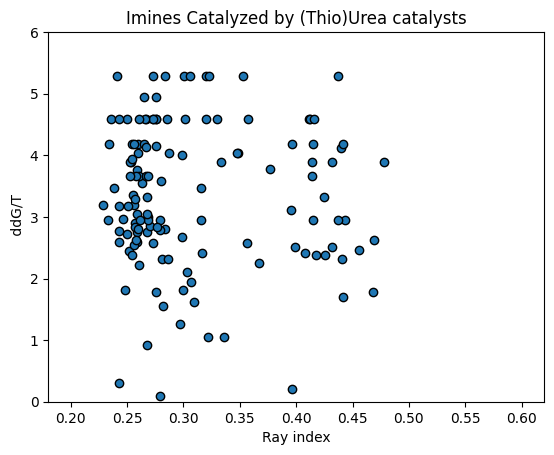

In [161]:
meanee,meaneet,counts,cats = Analyze_cats("(Thio)Urea",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by (Thio)Urea catalysts')

plt.xlim([0.18,0.62])
plt.ylim([0,6])

(0.0, 6.0)

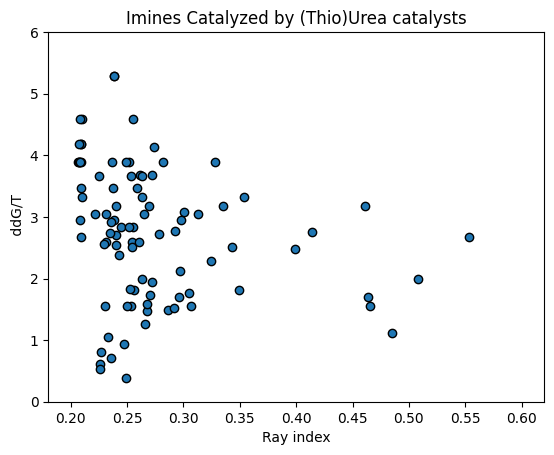

In [160]:
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by (Thio)Urea catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

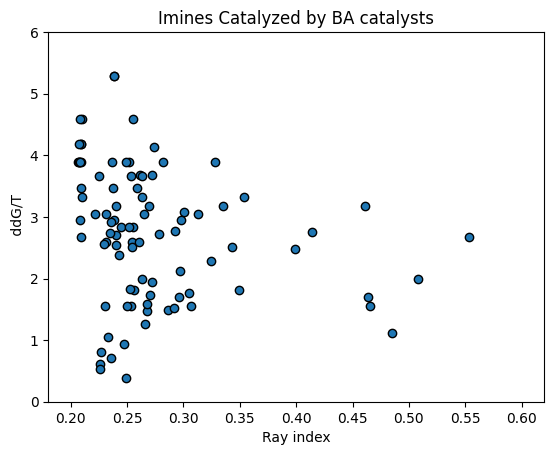

In [159]:
meanee,meaneet,counts,cats = Analyze_cats("BA",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by BA catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

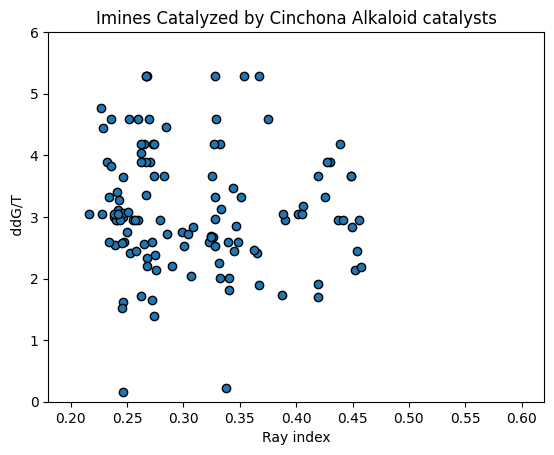

In [158]:
meanee,meaneet,counts,cats = Analyze_cats("Cinchona Alkaloid",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Cinchona Alkaloid catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

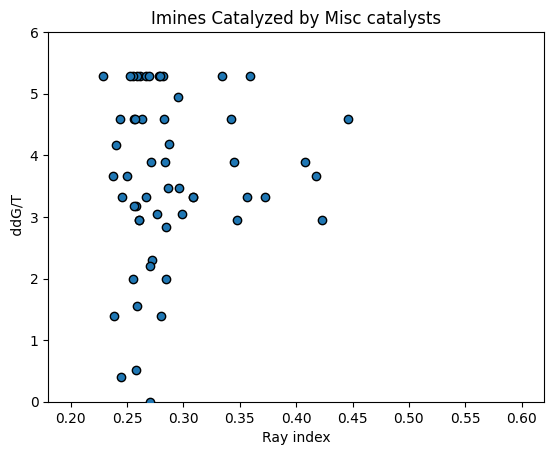

In [157]:
meanee,meaneet,counts,cats = Analyze_cats("Misc",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Misc catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipyke

(0.0, 6.0)

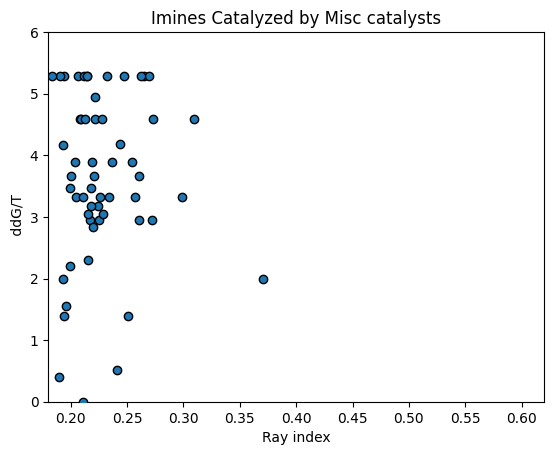

In [175]:
meanee,meaneet,counts,cats = Analyze_cats("Misc",0.7,0.5)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Misc catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

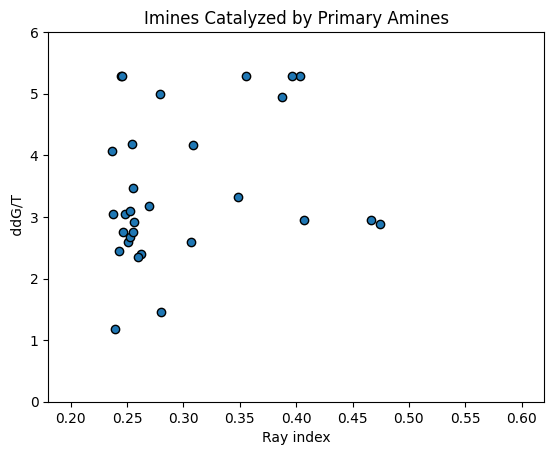

In [155]:
meanee,meaneet,counts,cats = Analyze_cats("Primary Amine",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Primary Amines')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

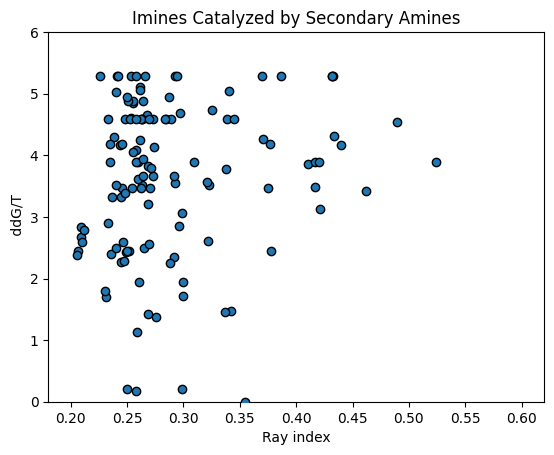

In [154]:
meanee,meaneet,counts,cats = Analyze_cats("Secondary Amine",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Secondary Amines')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

/tmp/ipykernel_1780680/429225088.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=df_temp["ee"]/(df_temp["Temp"]+273)
/tmp/ipykernel_1780680/429225088.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-df_temp["ee"])/2
/tmp/ipykernel_1780680/429225088.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

(0.0, 6.0)

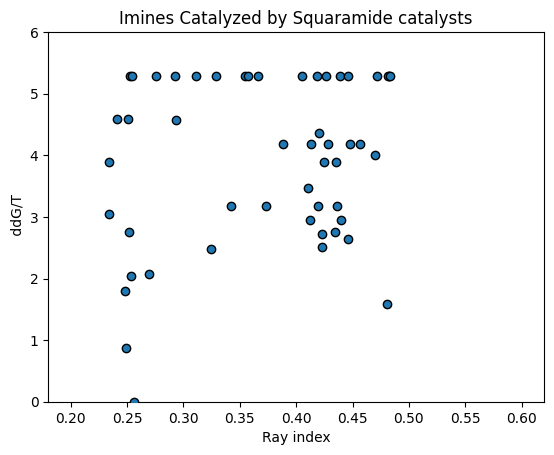

In [153]:
meanee,meaneet,counts,cats = Analyze_cats("Squaramide",0.8,0.6)
plt.scatter(counts,meaneet, edgecolor='black', zorder=15, marker='o')
plt.xlabel('Ray index')
plt.ylabel(' ddG/T')
plt.title('Imines Catalyzed by Squaramide catalysts')
plt.xlim([0.18,0.62])
plt.ylim([0,6])

In [12]:
ID_sub_grid = []
adjeciency_mat_sub = []
adjeciency_mat_cat = []
candidates = []
counts = []
cats = []
df_temp= full_df[full_df["Catalyst_Type"]=="Secondary Amine"]
sub_uniq = np.unique(df_temp.Catalyst)

for i in range(len(sub_uniq)):
        ID, adj, cand_ids = make_grid(sub_uniq[i], find_cand=True,atom_type="N",Degree=3)
        
        ID_sub_grid.append(ID)
        adjeciency_mat_sub.append(adj)
        candidates.append(cand_ids)
        if len(cand_ids)==1:
                center = ID[cand_ids[0]]
        
                lines = create_lines_from_adjacency_matrix(ID, adj,cand_ids[0])
                half_lines,count = place_evenly_spaced_lines(ID,lines,cand_ids[0], center, 128,0.8,0.6,30,1.3)
                counts.append(count)
                cats.append(sub_uniq[i])
                

In [163]:
meanee=[]

meaneet=[]
ee=df_temp["ee"]
T=df_temp["Temp"]
df_temp["eeT"]=ee/(T+273)
df_temp["er"]=(100-ee)/2
er=df_temp["er"]
df_temp["ddg"]=0.001986*(T+273)*np.log((100-er)/er)
df_temp["ddgT"]=0.001986*np.log((100-er)/er)
for i in range(len(cats)):
    meanee.append(df_temp[df_temp["Catalyst"]==cats[i]]["ddg"].mean())
    meaneet.append(df_temp[df_temp["Catalyst"]==cats[i]]["ddgT"].mean())

/tmp/ipykernel_1780680/2083966877.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["eeT"]=ee/(T+273)
/tmp/ipykernel_1780680/2083966877.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_temp["er"]=(100-ee)/2
/tmp/ipykernel_1780680/2083966877.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

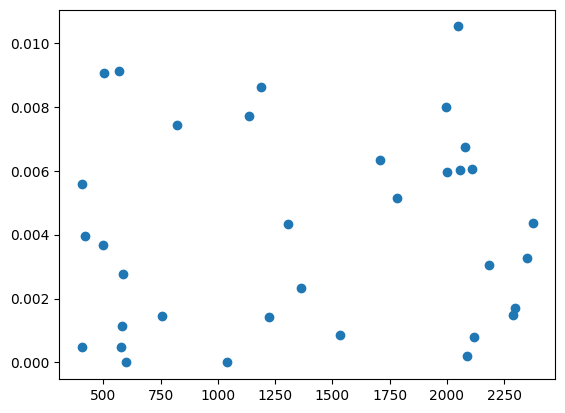

In [165]:
plt.scatter(counts,meaneet)

In [31]:
def calculate_percentage_no_clashes(half_lines, grid, center):
    """
    Calculate the percentage of lines that do not have any clashes with occupied points in different octants.

    Parameters:
        half_lines (list): A list of half-lines.
        grid_shape (tuple): The shape of the 3D grid (x, y, z).
        center (tuple): The coordinates of the center point (x_center, y_center, z_center).

    Returns:
        dict: A dictionary containing the percentage of lines without clashes for each octant.
    """
    grid_shape = np.shape(grid)
    x_size, y_size, z_size = grid_shape
    octant_counts = {i: 0 for i in range(8)}
    x_center, y_center, z_center = center
    
    
    for half_line in half_lines:
        if  half_line[2]:
                # Determine the octant based on the center point
                octant = 0
                if half_line[0][-1][0] >= x_center:  # Check x-coordinate
                    octant += 1
                if half_line[0][-1][1] >= y_center:  # Check y-coordinate
                    octant += 2
                if half_line[0][-1][2] >= z_center:  # Check z-coordinate
                    octant += 4

                octant_counts[octant] += 1

    total_lines = len(half_lines)/8
    percentages = {octant: (count / total_lines) * 100 for octant, count in octant_counts.items()}
    
    return percentages

calculate_percentage_no_clashes(half_lines, sub_grid[0],center)


NameError: name 'half_lines' is not defined

In [15]:
import plotly.graph_objects as go
def plot_lines_and_positions(lines, center, positions, radius):
    fig = go.Figure()

    # Plot lines
     # Plot lines
    for line_start, line_end in lines:
        x_vals = [line_start[0], line_end[0]]
        y_vals = [line_start[1], line_end[1]]
        z_vals = [line_start[2], line_end[2]]
        fig.add_trace(go.Scatter3d(x=x_vals, y=y_vals, z=z_vals, mode='lines', line=dict(color='blue')))





    # Plot positions
    xs, ys, zs = zip(*positions)
    fig.add_trace(go.Scatter3d(x=xs, y=ys, z=zs, mode='markers', marker=dict(color='red', size=3)))

    # Plot the center point
    
    fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], mode='markers', marker=dict(color='green', size=6)))

    # Plot sphere with radius around the center point
    for point in positions:
        if point!=center:
            u = np.linspace(0, 2 * np.pi, 100)
            v = np.linspace(0, np.pi, 100)
            x = radius * np.outer(np.cos(u), np.sin(v)) + point[0]
            y = radius * np.outer(np.sin(u), np.sin(v)) + point[1]
            z = radius * np.outer(np.ones(np.size(u)), np.cos(v)) + point[2]
            fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.3))

    # Update layout
    fig.update_layout(scene=dict(aspectmode='data'), title='Lines and Positions Visualization')

    # Show plot
    #fig.show()
    fig.write_html("mol.html")

# Example usage:
N = 20             # Number of evenly spaced lines
radius = 0.5        # Radius of the sphere
id=17
lines = create_lines_from_adjacency_matrix(ID_sub_grid[id], adjeciency_mat_sub[id],candidates[id][0])

plot_lines_and_positions(lines, ID_sub_grid[id][candidates[id][0]], ID_sub_grid[id], radius)

In [167]:
candidates[10]

[6]